# Import Shit

In [2]:
import os
import pandas as pd
from talib import abstract
import numpy as np
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [3]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)


we are going to start with candleStick 

In [4]:
from pandas_datareader import data
import pandas as pd
from datetime import date
from numpy import cov, correlate,corrcoef

start_date = '2015-01-01'
end_date = date.today()

global BTC
BTC = pd.DataFrame(data.DataReader('BTC-USD','yahoo',start_date,end_date)).rename(columns={'High': 'high', 'Low': 'low','Close':'close','Open':'open','Volume':'volume'}).drop(columns={'Adj Close'})

In [5]:
def convertToDateTime(date, time):
    series = []
    for d,t in zip(date, time):
        series.append(str(d) + "|" +t)
    return pd.to_datetime(series, format='%Y%m%d|%H:%M:%S', errors='coerce')

In [6]:
indi = {
    'func' : ['STOCH','sma','sar','MACD','BBANDS','HT_TRENDLINE'],
    'para' : [{'fastk_period': 5,
              'slowk_period': 3,
              'slowk_matype': 0,
              'slowd_period': 3,
              'slowd_matype': 0},
             {
                 'timeperiod': 25
             },
             {
                 'acceleration':0.02,
                 'maximum': 0.2
             },
             {},
             {},
             {}]
}
patternRec = {
    'func': [
        'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE',
        'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS',
        'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY',
        'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLADVANCEBLOCK',
        'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU',
        'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER',
        'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING',
        'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE',
        'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI',
        'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD',
        'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS', 'CDLINNECK',
        'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH',
        'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU',
        'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR',
        'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS',
        'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE',
        'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI',
        'CDLTASUKIGAP', 'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER',
        'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS'
    ],
    'para': []
}
for i in range(0, len(patternRec['func'])):
    patternRec['para'].append(dict())
indi['func'].extend(patternRec['func'])
indi['para'].extend(patternRec['para'])
#defining the rule that we are going to use
rule = {
    'spread': 25,
    'profit': 100,
    'stop_loss': 150
}

In [7]:
def addLag(df, serie, n=1, r=1):
    for i in range (0,n):
        orignal = df[serie]
        modified = orignal.shift((i+1) * r)
        newdf = pd.DataFrame(data= {
            serie + 'lag' + str((i+1) * r) : modified
        })
        df = pd.concat([df,newdf],axis = 1)
    return df

In [37]:
TA_ARRAY = None
COMPOSED_ARRAY = None

def genTA(composed, inputs,indi):
    global TA_ARRAY
    global COMPOSED_ARRAY
    output = dict()
    print("new composed" + str(composed.shape))
    for i in range(0, len(indi['func'])):
        calculated = np.asarray(abstract.Function(indi['func'][i])(inputs, **(indi['para'][i])))
        for j in range(0,len(abstract.Function(indi['func'][i]).output_names)):
            if len(calculated.shape) == 2:
                output[abstract.Function(indi['func'][i]).output_names[j]] = calculated[j]
            else :
                if abstract.Function(indi['func'][i]).output_names[j] == "real" or abstract.Function(indi['func'][i]).output_names[j] == 'integer':
                    output[abstract.Function(indi['func'][i]).info['name']] = calculated
                else :
                    output[abstract.Function(indi['func'][i]).output_names[j]] = calculated
    TA = pd.DataFrame(data=output).iloc[1:]
    print('TA shape:' + str(TA.shape))
    print(TA.index)
    print('composed shape' + str(composed.shape))
    composed['sorting'] = TA.index
    merged = composed.merge(TA,right_index=True,left_on='sorting')
    #return pd.concat([composed,TA],axis = 0)
    return merged

In [60]:
def applyRule(x, rule):
    if x['diff'] > 10:
        return 0
    elif x['diff'] < -10:
        return 1
    else:
        return 2
    
    

def calProfit(df,rule):
    LOOKINGFORWARD = 5
    FACTORING = ['high','low','diff']
    for factor in FACTORING:
        df = addLag(df, factor, LOOKINGFORWARD, -1)
    dropList = list()
    print(df.info())
    for factor in FACTORING:
        for i in range (0,LOOKINGFORWARD):
            dropList.append(factor + 'lag' + str((i+1) * -1))
    result = df.progress_apply(lambda x: applyRule(x,rule), axis=1)
    df['signal'] = result
    df = df.drop(dropList,axis = 1)
    return df

In [15]:
def prepDataFrame(pfilename, indicator):
    df = pd.read_csv(pfilename)
    openp = df.loc[1:, 'open'].to_numpy()
    closep = df.loc[1:, 'close'].to_numpy()
    highp = df.loc[1:, 'high'].to_numpy()
    lowp = df.loc[1:, 'low'].to_numpy()
    volumep = df.loc[1:, 'volume'].to_numpy()
    datep = df.loc[1:, 'Date'].tolist()
    timep = df.loc[1:, 'Timestamp'].tolist()
    medianp = (np.asarray(highp) + np.asarray(lowp)) / 2
    del df
    inputs = {
        'open': openp,
        'close': closep,
        'high': highp,
        'low': lowp,
        'volume': volumep
    }
    dat = {
        'time': convertToDateTime(datep, timep),
        'open': openp,
        'close': closep,
        'high': highp,
        'low': lowp,
        'median': medianp,
        'volume': volumep
    }
    composed = pd.DataFrame(data=dat)
    diff = np.diff(composed['close'])
    composed = addLag(composed,'close',1)
    composed = composed.iloc[1:,]
    composed['diff'] = diff
    composed = calProfit(composed, rule)
    composed = genTA(composed, inputs, indicator)
    composed = addLag(composed, 'diff', 5)
    composed = composed.iloc[70:composed.shape[0]-10, :]
    composed = composed.drop(['diff'],axis = 1)
    composed = addLag(composed,'signal',-1)
    composed['signal'] = composed['signallag1']
    composed = composed.drop(['signallag1'],axis = 1)
    return composed

In [16]:
def preProcessing(df, indicator):
    '''
        factor: time,open,close,high,low,median,volume
    '''
    composed = df
    inputs = {
        'open': composed['open'],
        'close': composed['close'],
        'high': composed['high'],
        'low': composed['low'],
        'volume': composed['volume']
    }
    composed['median'] = (np.asarray(composed['high']) + np.asarray(composed['low'])) / 2
    diff = np.diff(composed['close'])
    composed = addLag(composed,'close',1)
    composed = composed.iloc[1:,]
    composed['diff'] = diff
    composed = calProfit(composed, rule)
    composed = genTA(composed, inputs, indicator)
#    composed = addLag(composed, 'diff', 5)
    composed = composed.iloc[70:composed.shape[0]-10, :]
    composed = composed.drop(['diff','closelag1'],axis = 1)
    return composed

In [17]:
from sklearn.utils import shuffle
def saveDataSet(df,train_ratio = 0.80):
    df = shuffle(df)
    trainlen = int(df.shape[0]*train_ratio)
    testlen = df.shape[0] - trainlen
    train = df.head(trainlen+1)
    test = df.tail(testlen)
    trainfile = savefilename[:-4] + 'train_' + str(round(train_ratio,2)) + '.csv'
    testfile = savefilename[:-4] + 'test_' + str(round(1-train_ratio,2)) + '.csv'
    train.to_csv(trainfile)
    test.to_csv(testfile)
    df.to_csv(savefilename[:-4] + "whole.csv")

In [61]:
output = preProcessing(BTC,indi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1886 entries, 2015-01-02 to 2020-03-05
Data columns (total 23 columns):
high         1886 non-null float64
low          1886 non-null float64
open         1886 non-null float64
close        1886 non-null float64
volume       1886 non-null int64
median       1886 non-null float64
closelag1    1886 non-null float64
diff         1886 non-null float64
highlag-1    1885 non-null float64
highlag-2    1884 non-null float64
highlag-3    1883 non-null float64
highlag-4    1882 non-null float64
highlag-5    1881 non-null float64
lowlag-1     1885 non-null float64
lowlag-2     1884 non-null float64
lowlag-3     1883 non-null float64
lowlag-4     1882 non-null float64
lowlag-5     1881 non-null float64
difflag-1    1885 non-null float64
difflag-2    1884 non-null float64
difflag-3    1883 non-null float64
difflag-4    1882 non-null float64
difflag-5    1881 non-null float64
dtypes: float64(22), int64(1)
memory usage: 433.6 KB
None



new composed(1886, 9)
TA shape:(1886, 72)
RangeIndex(start=1, stop=1887, step=1)
composed shape(1886, 9)


In [40]:
output

,high,low,open,close,volume,median,signal,sorting,slowk,slowd,...,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-13,294.497986,285.337006,294.118011,285.337006,31421500,289.917496,1,71,70.267154,77.704271,...,0,0,0,0,0,0,0,0,0,0
2015-03-14,286.342010,280.976013,284.441986,281.885010,22612300,283.659012,1,72,42.607213,64.230741,...,0,0,0,0,0,0,0,0,0,0
2015-03-15,286.528992,280.996002,281.424988,286.393005,11970100,283.762497,0,73,27.176222,46.683530,...,0,0,0,0,0,0,0,0,0,0
2015-03-16,294.112000,285.684998,285.684998,290.592987,21516100,289.898499,0,74,32.485235,34.089557,...,0,0,0,0,0,0,0,0,0,0
2015-03-17,292.364990,284.373993,290.595001,285.505005,21497200,288.369492,1,75,42.060715,33.907391,...,0,0,0,0,0,0,0,0,0,0
2015-03-18,285.335999,249.869995,285.066986,256.299011,57008000,267.602997,1,76,35.904440,36.816796,...,0,0,0,0,0,0,0,0,0,0
2015-03-19,264.243988,248.636002,255.880005,260.928009,52732000,256.439995,0,77,25.018236,34.327797,...,0,0,0,0,0,0,0,0,0,0
2015-03-20,264.847992,259.161987,260.955994,261.748993,18456700,262.004990,2,78,23.465369,28.129348,...,100,0,0,0,0,0,0,0,0,0
2015-03-21,262.196014,255.649994,261.644012,260.024994,17130100,258.923004,1,79,27.303041,25.262215,...,0,0,0,0,0,0,0,0,0,100


In [80]:
output.to_csv('something.csv')

In [ ]:
btcfilename = 'btc.csv'
composed = prepDataFrame(btcfilename,indi)

In [62]:
unique, counts = np.unique(output['signal'], return_counts=True)
counts

array([647, 524, 635])

In [ ]:
output.isnull().sum().max()

In [ ]:
saveDataSet(composed)

In [ ]:
composed.shape

# AutoML

In [63]:
from sklearn.model_selection import train_test_split
train=output.sample(frac=0.8,random_state=200) #random state is a seed value
test=output.drop(train.index)
train.fillna(0).to_csv('train.csv')
test.fillna(0).to_csv('test.csv')

In [64]:
import autogluon as ag
from autogluon import TabularPrediction as task
train_data = task.Dataset(file_path='train.csv')
dirr = 'agModels-predictClass' # specifies folder where to store trained models
predictor = task.fit(train_data=train_data, label='signal', output_directory=dirr,problem_type='multiclass')

Loaded data from: train.csv | Columns = 81 / 81 | Rows = 1445 -> 1445
Beginning AutoGluon training ...
Preprocessing data ...
	Data preprocessing and feature engineering runtime = 0.62s ...
AutoGluon will gauge predictive performance using evaluation metric: accuracy
To change this, specify the eval_metric argument of fit()
Fitting model: RandomForestClassifierGini ...
	0.93s	 = Training runtime
	0.8304	 = Validation accuracy score
Fitting model: RandomForestClassifierEntr ...
	0.9s	 = Training runtime
	0.8166	 = Validation accuracy score
Fitting model: ExtraTreesClassifierGini ...
	0.8s	 = Training runtime
	0.8339	 = Validation accuracy score
Fitting model: ExtraTreesClassifierEntr ...
	0.81s	 = Training runtime
	0.8166	 = Validation accuracy score
Fitting model: KNeighborsClassifierUnif ...
	0.03s	 = Training runtime
	0.5294	 = Validation accuracy score
Fitting model: KNeighborsClassifierDist ...
	0.03s	 = Training runtime
	0.5398	 = Validation accuracy score
Fitting model: LightGBMC

In [65]:
test_data = task.Dataset(file_path='test.csv')
y_test = test_data['signal']
test_data_nolabel = test_data.drop(labels=['signal'],axis=1)
y_pred = predictor.predict(test_data_nolabel)
y_pred_proba = predictor.predict_proba(test_data_nolabel)
predictor.leaderboard(test_data)

Loaded data from: test.csv | Columns = 81 / 81 | Rows = 360 -> 360


                         model  score_test  score_val   fit_time  pred_time  stack_level
0   weighted_ensemble_l1        0.883333    0.892734   0.497878   0.000447   1          
1   CatboostClassifier          0.880556    0.865052   6.075983   0.020041   0          
2   LightGBMClassifier          0.875000    0.875433   2.357421   0.025653   0          
3   LightGBMClassifierCustom    0.869444    0.875433   8.280917   0.038201   0          
4   NeuralNetClassifier         0.863889    0.854671   10.159815  1.456121   0          
5   ExtraTreesClassifierEntr    0.855556    0.816609   0.814636   0.226764   0          
6   RandomForestClassifierGini  0.852778    0.830450   0.928637   0.225637   0          
7   ExtraTreesClassifierGini    0.850000    0.833910   0.800282   0.335429   0          
8   RandomForestClassifierEntr  0.838889    0.816609   0.898220   0.226381   0          
9   KNeighborsClassifierDist    0.655556    0.539792   0.030850   0.129799   0          
10  KNeighborsClassif

,model,score_test,score_val,fit_time,pred_time,stack_level
0,weighted_ensemble_l1,0.883333,0.892734,0.497878,0.000447,1
1,CatboostClassifier,0.880556,0.865052,6.075983,0.020041,0
2,LightGBMClassifier,0.875000,0.875433,2.357421,0.025653,0
3,LightGBMClassifierCustom,0.869444,0.875433,8.280917,0.038201,0
4,NeuralNetClassifier,0.863889,0.854671,10.159815,1.456121,0
5,ExtraTreesClassifierEntr,0.855556,0.816609,0.814636,0.226764,0
6,RandomForestClassifierGini,0.852778,0.830450,0.928637,0.225637,0
7,ExtraTreesClassifierGini,0.850000,0.833910,0.800282,0.335429,0
8,RandomForestClassifierEntr,0.838889,0.816609,0.898220,0.226381,0
9,KNeighborsClassifierDist,0.655556,0.539792,0.030850,0.129799,0


In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[111,  16,   6],
       [  4,  84,   6],
       [  7,   3, 123]])

<IPython.core.display.Javascript object>


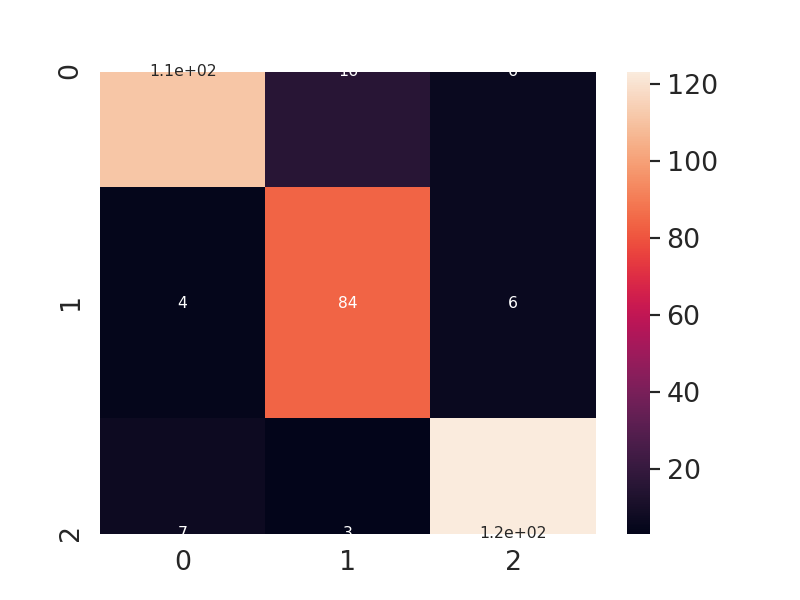

In [79]:
%matplotlib notebook
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(3), range(3))
#plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

# Feature importance

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1,n_jobs=-1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(df.drop(columns=['Date']), target)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

# Hurst Exponent

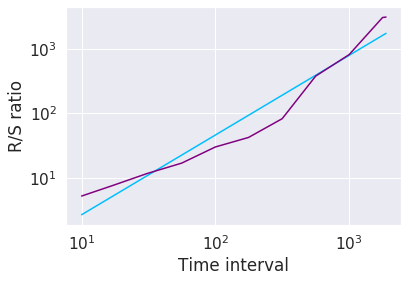

H=1.2380, c=0.1545


In [85]:
from hurst import compute_Hc, random_walk
import matplotlib.pyplot as plt
%matplotlib inline  

# Use random_walk() function or generate a random walk series manually:
# series = random_walk(99999, cumprod=True)
np.random.seed(42)
random_changes = 1. + np.random.randn(99999) / 1000.
series = np.cumprod(random_changes)  # create a random walk from random changes

# Evaluate Hurst equation
H, c, data = compute_Hc(BTC['median'], kind='price', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.plot(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

# Hurst exponent perdiction

In [84]:
df = pd.read_csv('something.csv')
target = df['signal']
df = df.drop(columns=['signal'])

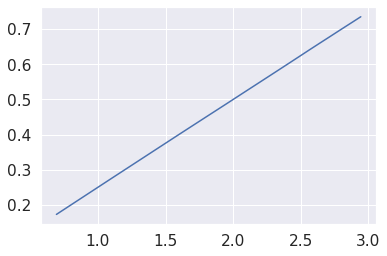

hurst =  0.49796728936589496


In [93]:
H, c, data = compute_Hc(df['close'], kind='price', simplified=True)
